<a href="https://colab.research.google.com/github/torrhen/data_science/blob/main/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### Simple linear regression

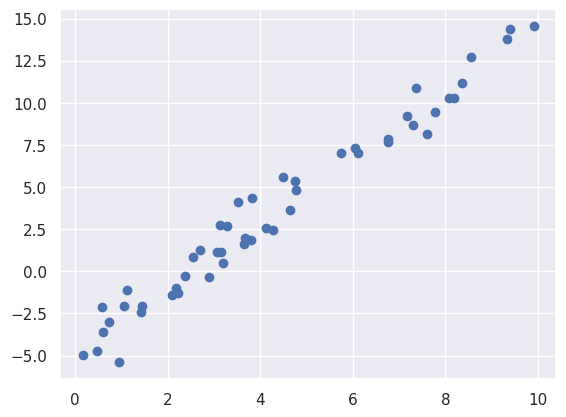

In [31]:
RAND_SEED = 1
N = 50
# create dataset
rand = np.random.RandomState(RAND_SEED)
X = 10 * np.random.rand(N) # uniform distribution [0, 10]
y = 2 * X - 5 + rand.randn(N) # y = 2x - 5 + standard normal error
# plot dataset
plt.scatter(X, y)

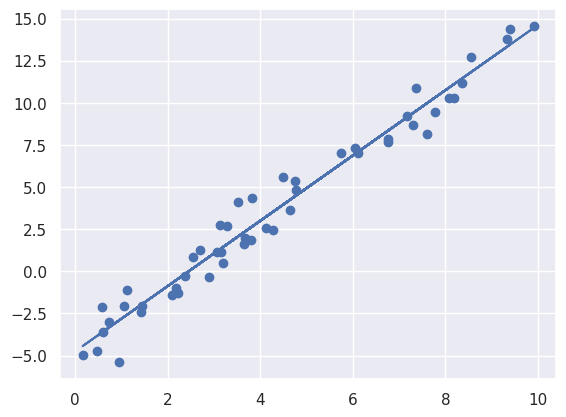

In [32]:
from sklearn.linear_model import LinearRegression

# add addition axis to feature data
X = X[:, np.newaxis]
# train linear regression model on data
linear_model = LinearRegression().fit(X, y)
# predict using model
y_preds = linear_model.predict(X)

# plot prediction
plt.scatter(X, y)
plt.plot(X, y_preds)

In [33]:
# show the learned parameters of the model
print(f"a0:\t{linear_model.intercept_}")
print(f"a1:\t{linear_model.coef_.item()}")

a0:	-4.754973803159372
a1:	1.9377575908468851


### Multiple linear regression

In [34]:
RAND_SEED = 1
N = 100

# create multi-variate dataset
rand = np.random.RandomState(RAND_SEED)
X = rand.rand(N, 3) # (100, 3) feature data
W = np.array([1.5, -2., 1.]) # (3,) weight vector
# y = X @ W + 0.5
y = 0.5 + np.dot(X, W) # (100,) target vector

In [35]:
# train multiple linear regression model
mult_linear_regression = LinearRegression().fit(X, y)
# predict y with W'
y_preds = mult_linear_regression.predict(X)

# print predicted parameters W' and intercept
print(f"a0':\t{mult_linear_regression.intercept_:.2f}")
print(f"a1':\t{mult_linear_regression.coef_[0]:.2f}")
print(f"a2':\t{mult_linear_regression.coef_[1]:.2f}")
print(f"a3':\t{mult_linear_regression.coef_[2]:.2f}")

a0':	0.50
a1':	1.50
a2':	-2.00
a3':	1.00


## Basis Function Regression

Linear Regression can be adapted to non-linear relationships between variables by transforming data into higher dimensions using a basis function. 

Linear relationships are easier to find in these higher dimensions and help to model non-linear relationships in lower dimensions.

Multiple linear regression
$$
y = {\theta}_{0} + {\theta}_{1}{x}_{1} + {\theta}_{2}{x}_{2} + ... + {\theta}_{n-1}{x}_{n-1} + {\theta}_{n}{x}_{n}
$$

Basis function regression
$$
y = {\theta}_{0} + {\theta}_{1}{\phi}_{1}({x}_{1}) + {\theta}_{2}{\phi}_{2}({x}_{2}) + ... + {\theta}_{n-1}{\phi}_{n-1}({x}_{n-1}) + {\theta}_{n}{\phi}_{n}({x}_{n})
$$

$$
y = {\theta}_{0} + \sum\limits_{i = 1}^{N} {\theta}_{i} {\phi}_{i}({x}_{i})
$$

**The model remains linear in the unknown parameters**, except that each feature has now been projected into some higher dimension before the model learns.

### Polynomial basis functions

For a **single dimension** input $x$, the polynomial basis functions are defined as:
$$
{\phi}_{n}({x}) = {x}^{n}
$$

Substituting into the general equation for basis function regression:

$$
y = {\theta}_{0} + {a}_{1}x + {\theta}_{2}{x}^{2} + ... + {\theta}_{n-1}{x}^{n-1} + {\theta}_{n}{x}^{n}
$$

$$
y = {\theta}_{0} + \sum\limits_{i = 1}^{n} {\theta}_{i}{x}^{i}
$$

In [36]:
RAND_SEED = 1
N = 50

# create dataset
rng = np.random.RandomState(RAND_SEED)
x = 10 * rng.rand(N) # uniform distribution between [0, 10]
# y = sin(x) + error
y = np.sin(x) + 0.1 * rng.randn(N)

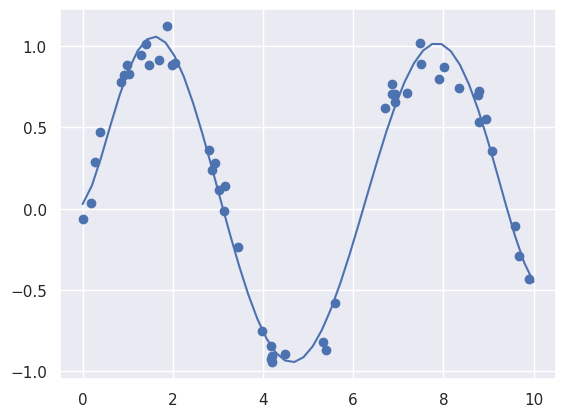

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# create polynomial basis regression pipeline using 7 degrees
polynomial_basis_regression = make_pipeline(PolynomialFeatures(degree=7),
                                            LinearRegression())

X = x[:, np.newaxis]

# train model on data
polynomial_basis_regression.fit(X, y)
# predict with model
xfit = np.linspace(0, 10, 50)
y_preds = polynomial_basis_regression.predict(xfit[:, np.newaxis])

# plot data
plt.scatter(x, y)
# plot predictions
plt.plot(xfit, y_preds)

### Gaussian RBF

Another way to model each sample of the data is as a sum of $n$ gaussian radial basis functions (RBF) instead of polynomial bases.

$$
\phi(x; {\mu}_{i}, \sigma) = {e}^{-\frac{{(x - {\mu}_{i})}^{2}}{{2\sigma}^{2}}}
$$

$$
y = {\theta}_{0} + \sum\limits_{i = 1}^{n} {\theta}_{i}{\phi(x; {\mu}_{i}, \sigma)}
$$

The value of $y$ depends on the radial distance between $x$ and the centre of each gaussian function. The equation remains linear in the parameters $\boldsymbol{\theta}$.

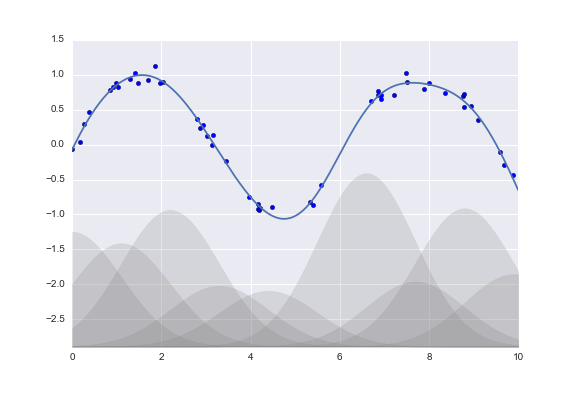

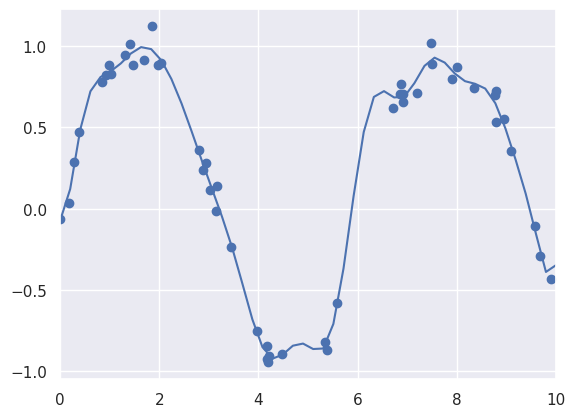

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
  def __init__(self, N, width_factor=2.0):
    self.N = N
    self.width_factor = width_factor

  # single implementation for all instances
  @staticmethod
  def _gauss_basis(x, y, width, axis=None):
    # find the distance between each datapoint and the N different centers
    arg = (x - y) / width # z score SD for each gaussian curve
    # calculate sum of gaussian functions for a single data point
    return np.exp(-0.5 * np.sum(arg ** 2, axis))

  # override method to be called by pipeline object
  def fit(self, X, y=None):
    # select N equal spaced centres between the smallest and biggest datapoint in X
    self.centers_ = np.linspace(X.min(), X.max(), self.N)
    # width of gaussian function is twice distance between centers, which overlap
    self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
    return self

  # override method to be called by pipeline object
  def transform(self, X):
    return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

# create pipeline
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
# fit and transform data
gauss_model.fit(x[:, np.newaxis], y);
# evaluate pipeline using unseen data
x_fit = np.linspace(0, 10, 50)[:, np.newaxis]
y_fit = gauss_model.predict(x_fit)

# plot original data and prediction
plt.scatter(x, y)
plt.plot(x_fit, y_fit)
plt.xlim(0, 10);

### Regularization

Overfitting can occur if too many gaussian functions are chosen to fit the data

(-1.5, 1.5)

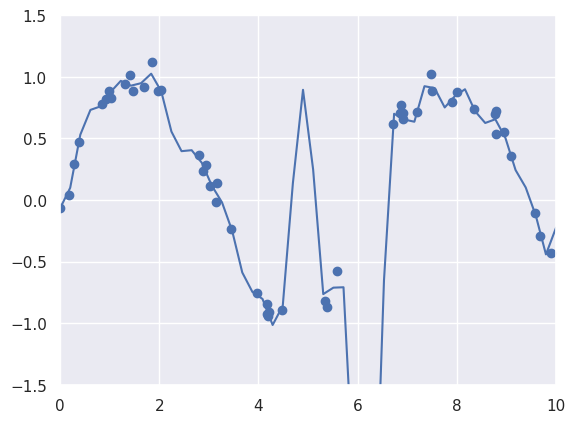

In [39]:
# gaussian RBF with 30 gaussian functions
overfit_model = make_pipeline(GaussianFeatures(30),
                              LinearRegression())

# linear regression model overfits on data
overfit_model.fit(x[:, np.newaxis], y)

# plot original data and predictions
plt.scatter(x, y)
plt.plot(x_fit, overfit_model.predict(x_fit))
plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)

#### Ridge Regression (L2)

Overfitting can be regulated by adding an additional term to penalise the sum of squared coefficients. Reducing the magnitude of coefficients prevents erratic fluctuations in the response for unseen values of $x$.

$$
{\vert\vert\boldsymbol{\theta}\vert\vert}_{2}^{2} = \lambda\sum\limits_{i = 1}^{N} {{\theta}_{i}}^{2}
$$

$\lambda$ is used to weight the importance of the penalising term. If $\lambda$ is small, the size of the coefficients ar ignored, if $\lambda$ is large the model attempts to constrain the size of coefficients.

(-1.5, 1.5)

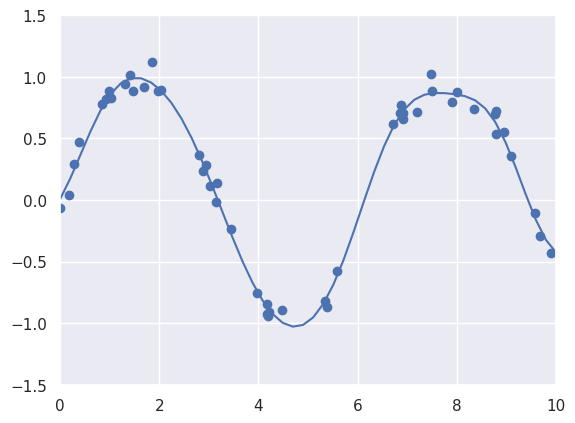

In [40]:
from sklearn.linear_model import Ridge

# ridge regression using gaussian RBF pipeline
ridge_regression = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
# ridge regression returns a smooth prediction curve without overfitting
ridge_regression.fit(x[:, np.newaxis], y)

# plot original data and predictions
plt.scatter(x, y)
plt.plot(x_fit, ridge_regression.predict(x_fit))
plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)

#### Lasso Regression (L1)

Lasso regression helps solve overfitting by introducing a term to penalising the sum of absolute values for the coefficients $\boldsymbol{\theta}$.

$$
{\vert\vert\boldsymbol{\theta}\vert\vert}_{1} = \lambda\sum\limits_{i = 1}^{N}\vert{\theta}_{i}\vert
$$

Lasso regression favors spare models by setting redudant features to zero. Lasso therefore acts as a way of feature selection to avoid overfitting and achieve good performance.

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e-03, tolerance: 2.065e-03
  model = cd_fast.enet_coordinate_descent(


(-1.5, 1.5)

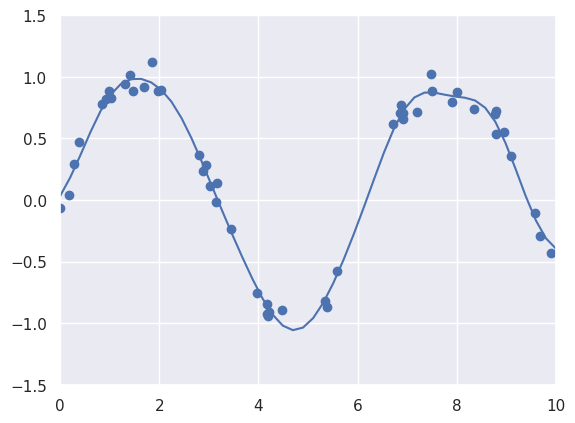

In [41]:
from sklearn.linear_model import Lasso

# lasso regression using gaussian RBF pipeline
lasso_regression = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
# lasso regression acts as a feature selector to avoid overfitting
lasso_regression.fit(x[:, np.newaxis], y)

# plot original data and predictions
plt.scatter(x, y)
plt.plot(x_fit, lasso_regression.predict(x_fit))
plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)